# HMM State Clustering
In this notebook we'll explore a post-hoc method for clustering HMM states.
The idea is, given an HMM which has been fit to data, we reduce the number of states hierarchically by merging pairs of states. Let's say we start with an HMM with K states. The idea is that we'll try merging every pair of states and see which merge makes the log-likelihood of the data go down the least. Once we find that pair, we have K-1 states, and we repeat this process until we have satisfactorily few states.

**Note**: This notebook is a little rough around the edges.

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(1)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [2]:
# Set the parameters of the HMM
time_bins = 1000   # number of time bins
num_states = 6   # number of discrete states
obs_dim = 2       # dimensionality of observation

# Make an HMM
true_hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

# Manually tweak the means to make them farther apart
thetas = 2 * np.pi * npr.rand(num_states)
true_hmm.observations.mus = 3 * np.column_stack((np.cos(thetas), np.sin(thetas)))

## For demonstration, make the last two states very similar

In [3]:
true_hmm.observations.mus[-1] = true_hmm.observations.mus[-2] + 1e-3 * npr.randn(obs_dim) 

## Sample some synthetic data

In [4]:
true_states, data = true_hmm.sample(time_bins)
true_ll = true_hmm.log_probability(data)

In [5]:
# Plot the observation distributions
lim = .85 * abs(data).max()
XX, YY = np.meshgrid(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100))
grid = np.column_stack((XX.ravel(), YY.ravel()))
input = np.zeros((data.shape[0], 0))
mask = np.ones_like(grid, dtype=bool)
tag = None
lls = true_hmm.observations.log_likelihoods(grid, input, mask, tag)

Below, we plot the samples obtained from the HMM, color-coded according to the underlying state. The solid curves show regions of of equal probability density around each mean. The thin gray lines trace the latent variable as it transitions from one state to another.

Text(0.5, 1.0, 'Observation Distributions')

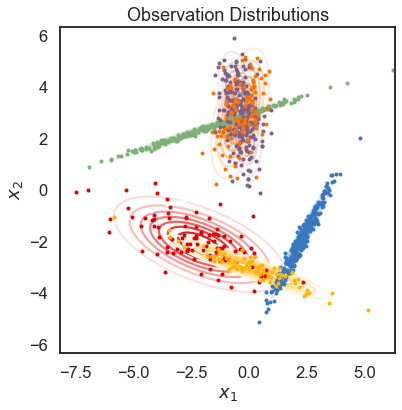

In [6]:
plt.figure(figsize=(6, 6))
for k in range(num_states):
    plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
    plt.plot(data[true_states==k, 0], data[true_states==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Observation Distributions")

Below, we visualize each component of of the observation variable as a time series. The colors correspond to the latent state. The dotted lines represent the "true" values of the observation variable (the mean) while the solid lines are the actual observations sampled from the HMM.

# Cluster states from the original HMM

The `merge_two_states` function below takes in a trained HMM, and indices of two states, s1 and s2. It outputs a new HMM where all states except for s1 and s2 are the same, along with the log-likelihood of the data under the new model.

Here's how we merge two states: In the E-step of the EM algorithm, we obtain a T x K table, which has the probability of being in state K at time T for every time point. To merge state k1 and k2, we take the two columns of the table corresponding to these two states and sum them. From this, we get a new table which is K-1 x T. We then run an M-step as normal to get the best parameters for our new K-1 state model, and evaluate the log likelihood.

**NOTE**: as written, the below function does not support inputs or masks, and it is limited to HMMs with stationary transitions. 

In [7]:
def merge_two_states(hmm, s1, s2, datas, observations="gaussian"):
    
    def collapse_and_sum_2d(arr, i, j, axis=0):
        assert axis <= 1
        out = arr.copy()
        if axis == 0:
            out[i,:] += out[j,:]
            return np.delete(out, j, axis=0)
        if axis == 1:
            out[:, i] += out[:, j]
            return np.delete(out, j, axis=1)
        
    K = hmm.K
    D = hmm.D
    assert K >= 2
    assert s1 < K
    assert s2 < K
    assert s1 != s2
    datas = datas if isinstance(datas, list) else [datas]
    inputs, masks, tags = [None], [None], [None]
    expectations = [hmm.expected_states(data, input, mask, tag)
                            for data, input, mask, tag in zip(datas, inputs, masks, tags)]
    
    # Merge expectations for 2 states
    expectations_new = []
    for (Ez, Ezz, py) in expectations:
        T_curr = Ez.shape[0]
        
        # Put merged expectations in first column
        Ez_new = collapse_and_sum_2d(Ez, s1, s2, axis=1)
        
        # Now merge Ezz
        # Ezz will have shape 1, K, K
        # so we get rid of the first dimension then add it back.
        Ezz_new = collapse_and_sum_2d(Ezz[0], s1, s2, axis=0)
        Ezz_new = collapse_and_sum_2d(Ezz_new, s1, s2, axis=1)
        Ezz_new = Ezz_new[None, :, :]
        
        expectations_new.append((Ez_new, Ezz_new, py))
    
    # Perform M-Step to get params for new hmm
    new_hmm = ssm.HMM(K-1, D, observations=observations)
    new_hmm.init_state_distn.m_step(expectations_new, datas, inputs, masks, tags)
    new_hmm.transitions.m_step(expectations_new, datas, inputs, masks, tags)
    new_hmm.observations.m_step(expectations_new, datas, inputs, masks, tags)
    
    # Evaluate log_likelihood
    expectations = [new_hmm.expected_states(data, input, mask, tag)
                    for data, input, mask, tag in zip(datas, inputs, masks, tags)]
    new_ll = new_hmm.log_prior() + sum([ll for (_, _, ll) in expectations])
    return new_ll, new_hmm
        

In [8]:
def plot_hmm(hmm, data):
    # Get the most likely state sequence
    states = hmm.most_likely_states(data)

    # Plot the observation distributions in the new model
    lim = .85 * abs(data).max()
    XX, YY = np.meshgrid(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100))
    grid = np.column_stack((XX.ravel(), YY.ravel()))
    input = np.zeros((grid.shape[0], 0))
    mask = np.ones_like(grid, dtype=bool)
    tag = None
    lls = hmm.observations.log_likelihoods(grid, input, mask, tag)

    plt.figure(figsize=(6, 6))
    for k in range(hmm.K):
        plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
        plt.plot(data[states==k, 0], data[states==k, 1], 'o', mfc=colors[k], mec='none', ms=4)

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Observation Distributions in merged HMM")
    

likelihood drop:  -1582.2029043893874


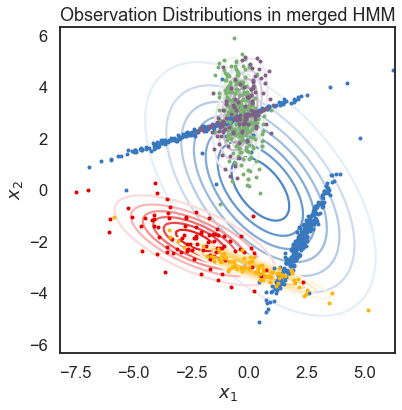

In [9]:
new_ll, new_hmm = merge_two_states(true_hmm, 0, 3, data)
print("likelihood drop: ", new_ll - true_ll)

plot_hmm(new_hmm, data)

Blue (0) and green (3) in the original model were not really similar, so we expected to see a big drop in likelihood in the merged model.  Let's do the same with the last two states, which we made similar by construction.

likelihood drop:  13.630303995832719


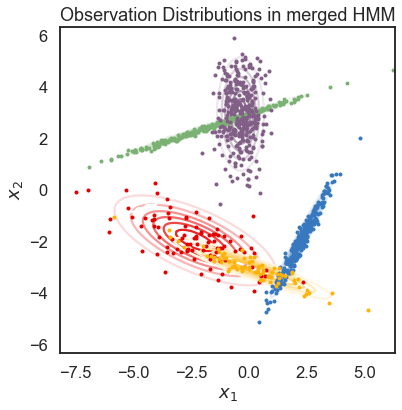

In [10]:
new_ll, new_hmm = merge_two_states(true_hmm, 4, 5, data)
print("likelihood drop: ", new_ll - true_ll)

plot_hmm(new_hmm, data)

Good! Looks like the drop in likelihood is actually a little lower for the "more similar" states.

## Make a pairwise similarity matrix

We can use the log-likelihood drop when merging states as a proxy for state "similarity." Two states which can be merged with minimal drop in likelihood might be considered similar.

In [11]:
def make_similarity_matrix(hmm, data):
    num_states = hmm.K
    init_ll = hmm.log_probability(data)
    similarity = np.nan * np.ones((num_states, num_states))
    merged_hmms = np.empty((num_states, num_states), dtype=object)
    for s1 in range(num_states-1):
        for s2 in range(s1+1, num_states):
            merged_ll, merged_hmm = merge_two_states(hmm, s1, s2, data)
            similarity[s1, s2] = merged_ll - init_ll
            merged_hmms[s1, s2] = merged_hmm
            
    return similarity, merged_hmms

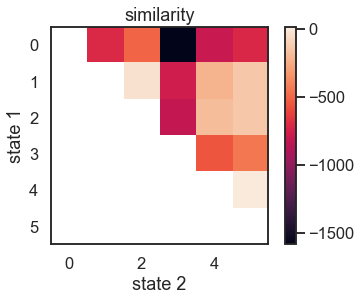

In [12]:
similarity, new_hmms = make_similarity_matrix(true_hmm, data)
im = plt.imshow(similarity)
plt.ylabel("state 1")
plt.xlabel("state 2")
plt.title("similarity")
plt.colorbar()

These merges are perhaps a little counterintuitive at first.  In terms of likelihood drop, the first two states to be merged woudl be red (1) and yellow (2).  Their means more fairly different than those of purple and orange, but they have relatively large variance.  Let's see what happens when we do this recursively.

## Hierarchical clustering by iteratively merging states
We start with a K state HMM, then merge possible pair of states k1 and k2. We can see which are the best two states to merge by checking the new log-likelihood. We then rinse and repeat for our new K-1 state HMM, tracking the log-likelihood as we go, until there is only 1 state left. After each merge, we can show the observation distribution and new similarity matrix.

In [13]:
def hierarchical_cluster(hmm, data, plot=True):
    num_states = hmm.K
    linkage = [None]
    likelihood_drops = [0]
    hmms = [hmm]
    
    if plot:
        plot_hmm(hmm, data)
    
    for i in range(num_states - 1):
        similarity, merged_hmms = make_similarity_matrix(hmms[-1], data)
        
        # Find the most similar states
        s1, s2 = np.where(similarity == np.nanmax(similarity))
        s1, s2 = s1[0], s2[0]
        linkage.append((s1, s2))
        likelihood_drops.append(similarity[s1, s2])
        hmms.append(merged_hmms[s1, s2])
        print("merging ", color_names[s1], "and", color_names[s2])
        
        if plot:
            plt.figure()
            im = plt.imshow(similarity)
            plt.ylabel("state 1")
            plt.xlabel("state 2")
            plt.title("similarity")
            plt.colorbar()
            
            plt.figure()
            plot_hmm(hmms[-1], data)
    
    return linkage, likelihood_drops, hmms

merging  dusty purple and orange
merging  red and amber
merging  red and faded green
merging  red and amber
merging  windows blue and red


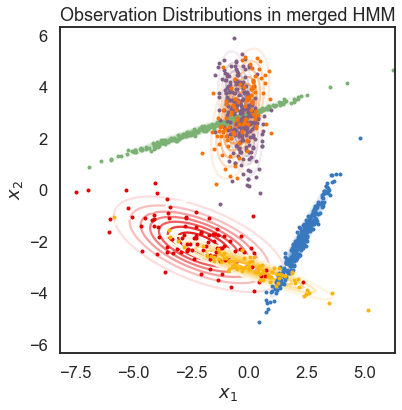

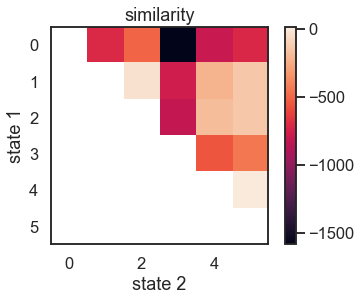

<Figure size 432x288 with 0 Axes>

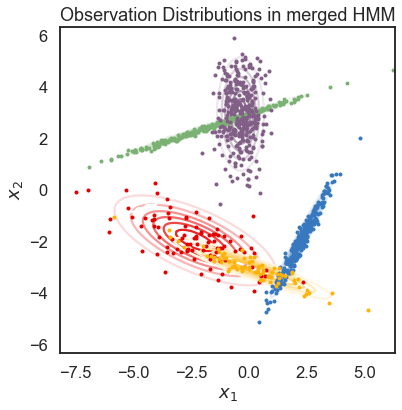

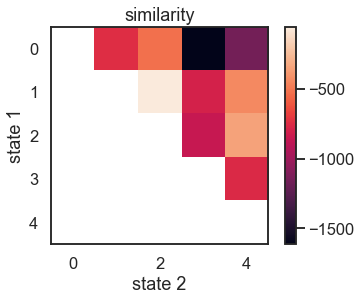

<Figure size 432x288 with 0 Axes>

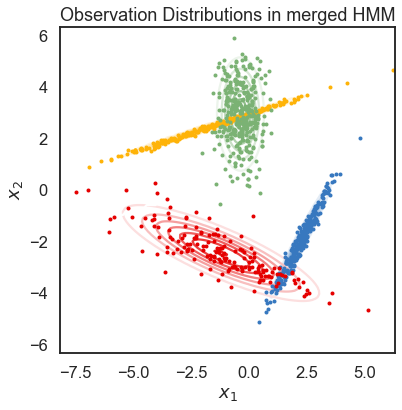

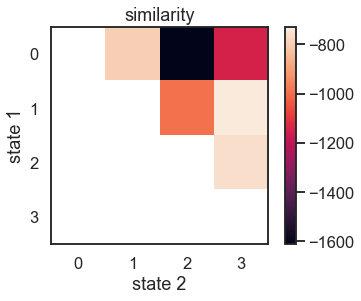

<Figure size 432x288 with 0 Axes>

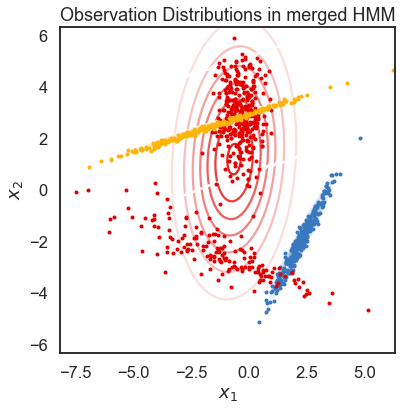

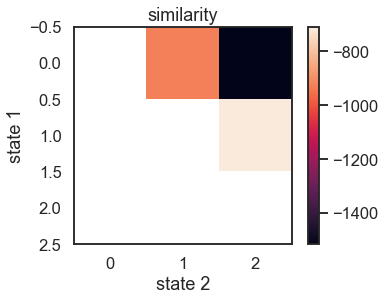

<Figure size 432x288 with 0 Axes>

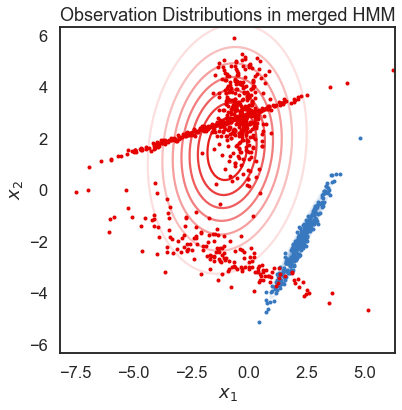

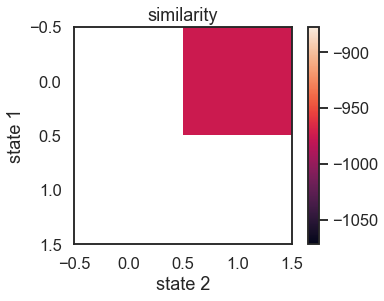

<Figure size 432x288 with 0 Axes>

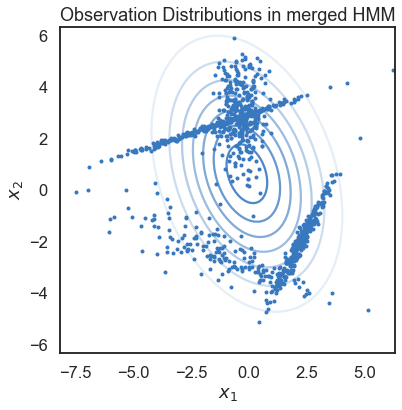

In [14]:
linkage, likelihood_drops, hmms = hierarchical_cluster(true_hmm, data)

## Now plot the dendrogram using likelihood drop as similarity

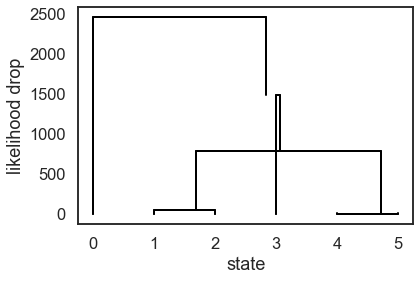

In [18]:
def dendrogram(num_states, linkage, likelihood_drops):
    plt.figure()
    
    def _plot_level(s1, s2, likelihood_drop, xs, offset):
        new_offset = offset - likelihood_drop
        for x in xs:
            plt.plot([x, x], [offset, new_offset], '-k', lw=2)
        plt.plot([xs[s1], xs[s2]], [new_offset, new_offset], '-k', lw=2)

        new_xs = xs.copy()
        new_xs[s1] = 0.5 * (xs[s1] + xs[s2]) + 0.2 * npr.randn()
        new_xs = np.concatenate([new_xs[:s2], new_xs[s2+1:]])
        return new_xs, new_offset
    
    xs = np.arange(num_states, dtype=float)
    offset = 0
    for (s1, s2), drop in zip(linkage[1:], likelihood_drops[1:]):
        xs, offset = _plot_level(s1, s2, drop, xs, offset)
        
    plt.xlabel("state")
    plt.ylabel("likelihood drop")
        
dendrogram(true_hmm.K, linkage, likelihood_drops)